<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Thymio-Project" data-toc-modified-id="Thymio-Project-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Thymio Project</a></span></li><li><span><a href="#Complete-Program" data-toc-modified-id="Complete-Program-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Complete Program</a></span><ul class="toc-item"><li><span><a href="#Thymio-preparation" data-toc-modified-id="Thymio-preparation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Thymio preparation</a></span></li><li><span><a href="#Main-program-description" data-toc-modified-id="Main-program-description-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Main program description</a></span><ul class="toc-item"><li><span><a href="#Initialization-and-decision-making" data-toc-modified-id="Initialization-and-decision-making-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Initialization and decision making</a></span></li><li><span><a href="#Data-acquisition" data-toc-modified-id="Data-acquisition-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Data acquisition</a></span></li><li><span><a href="#Control" data-toc-modified-id="Control-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Control</a></span></li></ul></li><li><span><a href="#Complete-program-execution" data-toc-modified-id="Complete-program-execution-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Complete program execution</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Define-the-state-machine" data-toc-modified-id="Define-the-state-machine-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Define the state machine</a></span><ul class="toc-item"><li><span><a href="#Define-the-data-structures" data-toc-modified-id="Define-the-data-structures-2.3.2.1"><span class="toc-item-num">2.3.2.1&nbsp;&nbsp;</span>Define the data structures</a></span></li><li><span><a href="#Define-the-state-functions-and-the-state-machine-itself" data-toc-modified-id="Define-the-state-functions-and-the-state-machine-itself-2.3.2.2"><span class="toc-item-num">2.3.2.2&nbsp;&nbsp;</span>Define the state functions and the state machine itself</a></span></li></ul></li><li><span><a href="#Program-execution" data-toc-modified-id="Program-execution-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Program execution</a></span><ul class="toc-item"><li><span><a href="#Adjusting-camera-position" data-toc-modified-id="Adjusting-camera-position-2.3.3.1"><span class="toc-item-num">2.3.3.1&nbsp;&nbsp;</span>Adjusting camera position</a></span></li><li><span><a href="#Execute-Program" data-toc-modified-id="Execute-Program-2.3.3.2"><span class="toc-item-num">2.3.3.2&nbsp;&nbsp;</span>Execute Program</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Vision" data-toc-modified-id="Vision-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Vision</a></span><ul class="toc-item"><li><span><a href="#Corner-detection" data-toc-modified-id="Corner-detection-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Corner detection</a></span></li><li><span><a href="#Image-Straightening" data-toc-modified-id="Image-Straightening-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Image Straightening</a></span></li><li><span><a href="#Obstacles-Processing" data-toc-modified-id="Obstacles-Processing-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Obstacles Processing</a></span></li><li><span><a href="#Location-of-endpoint-and-of-Thymio" data-toc-modified-id="Location-of-endpoint-and-of-Thymio-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Location of endpoint and of Thymio</a></span></li></ul></li><li><span><a href="#Path-planning" data-toc-modified-id="Path-planning-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Path planning</a></span><ul class="toc-item"><li><span><a href="#Initialise-path-planner" data-toc-modified-id="Initialise-path-planner-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Initialise path planner</a></span></li><li><span><a href="#Planning-phase" data-toc-modified-id="Planning-phase-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Planning phase</a></span></li><li><span><a href="#Query-Phase" data-toc-modified-id="Query-Phase-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Query Phase</a></span></li><li><span><a href="#Getting-the-path" data-toc-modified-id="Getting-the-path-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Getting the path</a></span></li><li><span><a href="#complete-pathplanning-demonstration" data-toc-modified-id="complete-pathplanning-demonstration-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>complete pathplanning demonstration</a></span></li></ul></li><li><span><a href="#Local-navigation,-avoidance-of-unexpected-obstacles" data-toc-modified-id="Local-navigation,-avoidance-of-unexpected-obstacles-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Local navigation, avoidance of unexpected obstacles</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filtering</a></span></li></ul></div>

# Thymio Project







In [ ]:
pip install pyserial

# Complete Program


In this section  the main execution of the program is presented and available to be executed with a thymio that is properly prepared. 
## Thymio preparation
The thymio should have 2 blue dots on it. 1 big, where the wheels are and 1 smaller on the front part. Those dots should be on a light blocking paper which is then mounted on the thymio. Furthermore there are some lights that can't be turned off. These should also be covered as well as possible.


<img src="documentation/ImagesForDocumentation/thymioTop.jpg"
     alt="Thymio Preparation 1"
     style="float: left; margin-right: 10px;width: 300px;" />

<img src="documentation/ImagesForDocumentation/thymioBottom.jpg"
     alt="Thymio Preparation 2"
     style="float: left; margin-right: 10px;width: 200px;" />



<img src="documentation/ImagesForDocumentation/thymioBehind.jpg"
     alt="Thymio Preparation 3"
     style="float: left; margin-right: 10px;width: 300px;" />
Left most Image shows the top and side cover points
Middle Image shows the bottom spots to cover
RIght most Image shows the behind spots to cover

If all these spots are covered it wont confuse the vision system.

## Main program description
The main program consists out of four parts. The first one is the initialization, in this part the different Connections are made, like the one to the camera and the thymio. It also generates the map and the path.The second Part Data acquisition takes data  from the different senors present. These are the camera, the horizontal facing infrared distance sensors and the internal speed measurement. These are then processed into the position and orientation of the robot and preprocessed to be able to make decisions in the second part. The second part is the state machine that takes the preprocessed data from the sensor part and decides whether it should follow a the path or if it should avoid path, and so on. The fourth part takes the decisions of the the second part and controls the robot with them and the data of the first part.

### Initialization and decision making
<img src="documentation/stateEventRobotics.jpg"
     alt="Robotics statemachine"
     style="float: left; margin-right: 5px;width: 700px;" />
To initialize everything properly, first the connection to the camera is established, when this fails everything else will also not work and it is necessary to setup the camera correctly. To facilitate this at the beginning the images captured by the camera are shown at the beginning. Then the connection to the thymio is made, also a very important component. If the connection was successful too, then everything can proceed to generate the map. For that the camera is used to capture the map and generate an occupancy grid. Then the path is planned by the path planner from the current thymio location to the goal. After that the main loop begins which is divided into 3 parts. The decision making part is manly the implementation of the state machine shown to the left without the Initialization part.
This means that the robot follows the path as long as it has not reached the goal or encounters a obstacle. If an obstacle is encountered the Obstacle avoidance is triggered and it is avoided until no obstacle is detected anymore. Then the robot proceeds to the same way point that he tried to steer to before. This happens until the goal is reached. If the thymio reaches the goal it stops.

### Data acquisition
The data from the different sensors is first processed before it is send into the control and the decision making part.
This means the position data from the camera is filtered with a kalman filter in combination with the odometry from the speed readings. This only happens when the position estimate from the camera is not unstable and jumping around. When this happens the data from the camera is ignored until it has stabilized. If the position estimate from the camera has stabilized again, it is then used again. This is necessary because sometimes the position reading from the camera jumps around. This in theory also enables the detection of kidnapping, but that is not implemented. Beside checking if the position given by the camera is stable, it is also check whether or not the thymio can be see by the camera. If this is not the case the robot relies on the odometry alone. Beside the data from the camera and the odometry the horizontal infrared distance sensors are also checks whether or not they see an obstacle. If they do, a flag is set to tell the state machine this fact.

### Control
In the control section of the main loop the path follower follows the path generated by the path planner. This path consists out of way points the robot has to reach. For that the path follower compares the current position of the thymio with the next way point, not the closest but the next in the list, even though they are save in an array, and then drives the robot towards it. If the goal is reached the robot then stops. If the decision making state machine says to stop the robot also stops. One would think that the obstacle avoidance is also located here. That is not the case becuase of the way it is coded. The obstacle avoidance is a function that stays inside itself until the obstacle is avoided. This means the obstacle avoidance is performed inside the state machine.

## Complete program execution
In this section one can execute the different cells one after the other to get the behavior described before. If they are not all executed in order then it wont work.

### Imports
All the imports necessary to run the program. This includes user defined files and library files.

In [1]:
#!pip install pyserial
#import standart libraries
import os
import sys
import time
import serial
import numpy as np
from numpy import linalg as LNG 
import math
import cv2
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
from skimage import exposure
from timeit import default_timer as timer

# Adding the src folder in the current directory as it contains the script
# with the Thymio class and all the files with the group generated functions and classes
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from Thymio import Thymio
#import functions made by group
from pathPlanning import pathPlaning
import ANN
import robot_control
import Vision
import sys

from kalman_filter import kalman_filt

### Define the state machine
In this section the state machine shown earlier is realized in code. To achieve that, 2 data structures are needed, one that holds the names of the states and one that holds all the data needed to make the decisions and afterwards the state functions are defined.

#### Define the data structures
The first data structure holds the state names used in the state machine. This is basically what in other languages is an enumeration or static variables. The second class is used to store data from the sensors and then only needing to hand over the object of this class, containing all the data needed to make decisions.

In [2]:
#class used to store the names of the states to be able to retrive the state functions from the dictionary 
#that serves as state machine
class stateNames_t:
    def __init__(self):
        self.planAcquired='planAcquired'
        self.newPath='newpath'
        self.checkingPath='checkingPath'
        self.underWay='underWay'
        self.obstacleAvoidance='obstalceAvoidance'
        self.goalReached='goalReached'
#this class is used as data transfer between the data acqusition part, the decision making part and the control part.
class FSMHelper:
    def __init__(self,thymio,equalTolerance,wayPointDistance,pathplanner):
        self.wasKidnapped=False
        self.tolerance=equalTolerance
        self.currentPosition=np.zeros((2,1))
        self.pathPlanner=pathplanner
        self.newPositionEstimate=0    
        self.thymio=thymio      
        self.obstacleDetected=False
        self.doStop=False
        self.goalReached=False
        self.goal=np.zeros((2,1))
        self.pathToFollow=np.array([[0],[0]])
        self.FSMStates=stateNames_t()
        self.straightenedImage=0
        self.wayPointReachedDistance=wayPointDistance
        self.followPath=False
        

#### Define the state functions and the state machine itself
In this sections all the state functions are defined. Each function is called when the state it represents is entered. Each state function then returns the name of the next state, that should be entered. This makes it possible that the state machine is a dictionary with the state names as keys and the state functions as items. To make the state machine to its job, the item with the current state name has to be retrieved, the state function, and executed. The name given by the executed state function is then the next state and the same can be done again.

In [3]:
def planAcquired(robot):     #starting state, the map is generated and preprocessed to enable path generation
    return robot.FSMStates.checkingPath      #go to check if a new path needs to be generated
    
def newPath(robot):#
    robot.pathToFollow=robot.pathPlanner.getOptimizedPath()
    print("path after Planner",robot.pathToFollow)
    return robot.FSMStates.checkingPath
    
def checkingPath(robot):
    if(np.size(robot.pathToFollow)!=0):
        robot.followPath=True
        return robot.FSMStates.underWay
    else:
        robot.followPath=False
        robot.doStop=True
        return robot.FSMStates.goalReached
    
def underWay(robot):
    if(robot.obstacleDetected==True):
        robot.followPath=False
        return robot.FSMStates.obstacleAvoidance
    else:
        return robot.FSMStates.planAcquired
    
def avoidObstacle(robot):     
    ANN.run_ann_without_memory(robot.thymio)
    return robot.FSMStates.checkingPath 

def goalReached(robot):
    robot.goalReached=True
    
    
#define the concrete stateName object to make the dictionary for the actual state machine
stateName=stateNames_t()
switch = {
    stateName.planAcquired     : planAcquired,
    stateName.newPath          : newPath,
    stateName.checkingPath     : checkingPath,
    stateName.underWay         : underWay,
    stateName.obstacleAvoidance: avoidObstacle,
    stateName.goalReached      : goalReached,
}
currentState=stateName.planAcquired
futureState=stateName.planAcquired

### Program execution

Now that the data structures needed to run the state machine and the state machine itself is defined in code, the program can be executed.

#### Adjusting camera position
<img src="documentation/"
     alt="Example Picture of camera view"
     style="float: left; margin-right: 5px;width: 700px;" />
The camera should see an image similar to the one shown here. All 4 red corner markers should be visible, the map should also fill out most of the image of the camera. It is also necessary that the colors are well visible and that the picture is not too bright. To help with this adjustment execute the code in the next cell

In [8]:
cameraIndex=1             #index 1 is the index of the specific machine used. it is highly likly that it is on other machines aswell
cv2.namedWindow("preview")
videoCapture = cv2.VideoCapture(cameraIndex)
if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')
videoCapture = cv2.VideoCapture(cameraIndex)
exposureOfCamera=-2.1          #initial exposure
videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera)
videoCapture.set(cv2.CAP_PROP_SATURATION ,120)

if not(videoCapture.isOpened()):
    raise Exception('could not connect to camera')

if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not connect to camera')
while rval:
    cv2.imshow("preview", frame)
    rval, frame = videoCapture.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
    elif(key== ord('w')):
        exposureOfCamera=exposureOfCamera+0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
    elif(key== ord('s')):    
        exposureOfCamera=exposureOfCamera-0.1
        print (videoCapture.set(cv2.CAP_PROP_EXPOSURE,exposureOfCamera),exposureOfCamera)
cv2.destroyWindow("preview")
cv2.destroyAllWindows()
cv2.VideoCapture(cameraIndex).release()

In [ ]:
ToDO: 
    wirte a separate chapter about the outlier elimination.
    

#### Execute Program
In this section the main control loop and the initialization can be executed. Connecting to the thymio should only be executed once.

In [5]:
th=Thymio.serial(port="COM6", refreshing_rate=0.1)

If the next cell is executed the thymio will begin moving after a certain amount of time. This waiting time is because of the map generation

Endpoint Coordinates:  (105.07892772550377, 9.951557294506962)


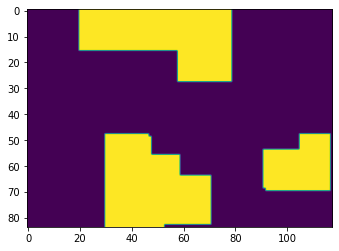

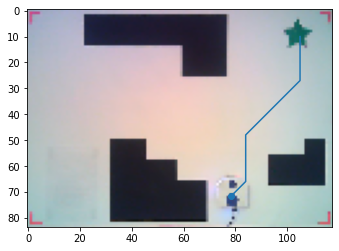

1e-06


NameError: name 'math' is not defined

In [6]:
#------- turn off all leds that can be controlled
th.set_var_array("leds.top", [0, 0, 0])
th.set_var_array("leds.bottom.right", [0, 0, 0])
th.set_var_array("leds.bottom.left", [0, 0, 0])

#------ start camera
cameraIndex=1             #index 1 is the index of the specific machine used. it is highly likly that it is on other machines aswell
videoCapture = cv2.VideoCapture(cameraIndex)
#-------set exposure to have a bright enough picture
videoCapture.set(cv2.CAP_PROP_EXPOSURE,-2.1)
if videoCapture.isOpened(): # try to get the first frame
    rval, frame = videoCapture.read()
else:
    rval = False
    raise Exception('could not read image!')

mask= cv2.imread('Images/Mondamask.JPG')           #read corner mask
if mask.size==0:
    raise Exception('Could not open Mask')
    
dimension_paper = [118.9,84.1] #cm A0
dim = (int(dimension_paper[1]),int(dimension_paper[0]))
# Switching red and blue channels
frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
mask[:, :, [0, 2]] = mask[:, :, [2, 0]]

#preprocess image data to facilitate map generation and thymio position accusition
p2_1, p98_1 = np.percentile(frame, (2, 98))
img_res1 = exposure.rescale_intensity(frame, in_range=(p2_1,p98_1))
img1_gray = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
threshold_bg=130
#------generate map from camera
percent = 0.9
while True:
        output = Vision.bg_clustering(img1_gray, (50,50),threshold_bg)
        corner_location = Vision.corner_detection(output,mask) # Get the location of the 4 corners
        img_straighten, M = Vision.four_point_transform(frame, corner_location) # Get the transformation matrix and the straighten img
        if(img_straighten.shape[0] > output.shape[0]*percent and img_straighten.shape[1] > output.shape[1]*percent):
            break
        else:
            rval, frame = videoCapture.read()
            frame[:, :, [0, 2]] = frame[:, :, [2, 0]]
            

im_dim = img_straighten.shape
obstacles = Vision.get_obstacles(img_straighten) 
thymio_coord = Vision.get_thymio_info(frame,M,dim,im_dim) 
endpoint_coord = Vision.get_endpoint_info(frame,M,dim,im_dim)
low_res_img = cv2.resize(img_straighten, dsize=((dim[1], dim[0])))

#---------make occupancy grid from map
occupancyGrid=cv2.resize(obstacles, dsize=((dim[1], dim[0])))
occupancyGrid=occupancyGrid>200
plt.imshow(occupancyGrid)
plt.show()
occupancyGrid=occupancyGrid.astype(float)
kernel2 = np.ones((7,7), np.uint8)
occupancyGrid = cv2.dilate(occupancyGrid, kernel2, iterations=2)

pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)

#give over the thymio connection and the tolerance for equality to 1e-6, the distance when it is considered way point reached
#and the path planner to use
robotStatus=FSMHelper(th,1e-6,0.5,pathPlanner)
robot_control.th=th      #give pathfollower the connection to the thymio
#---------start planning
robotStatus.pathPlanner.setGoal(np.asarray(endpoint_coord))
robotStatus.currentPosition=np.array([(thymio_coord[0][0]),(thymio_coord[0][1]),(thymio_coord[1])/180*np.pi])
robotStatus.pathPlanner.setStart(robotStatus.currentPosition[0:2])
robotStatus.pathToFollow=robotStatus.pathPlanner.getOptimizedPath()
estimatedRobotPose=robotStatus.currentPosition

#show path on image
originalPath=robotStatus.pathToFollow.copy() 
plt.imshow(low_res_img)
plt.scatter(thymio_coord[0][0],thymio_coord[0][1])
plt.plot(originalPath[0],originalPath[1])
plt.show()
#-------------path planning and map generation complete
%matplotlib qt

#constant kalman matrixes
A = np.array([[1,0,0],[0,1,0],[0,0,1]])
C = np.array([[1,0,0],[0,1,0],[0,0,1]])
Q = np.array([[0.1, 0, 0],[0, 0.1, 0],[0,0,0.1]]) # Dependent on the error (can be linked to stated as velocity, but velocity is not taken as state. )
R = np.array([[0.1, 0, 0],[0, 0.1, 0],[0,0,0.1]])
Q_ini = Q
X = np.array([[estimatedRobotPose[0]],[estimatedRobotPose[1]],[estimatedRobotPose[2]]], dtype = "float32")
L = []

timeElapsed=np.array([0,0], dtype = 'float64')

robotPositionUncertainty=np.zeros((3,3))         #variable to store the accuracy estimate from odmotry

currentState=stateName.planAcquired              #initialize state event
futureState=stateName.planAcquired
originalPath=robotStatus.pathToFollow.copy()    #store path before loop, loop removes waypoint from non original path
doPlotCounter=0                               #variable used to show the image taken of the camera after 10 loop executions
deltaT=0.0                                   # variable used to store the time needed to execute the loop once
tbefore=time.time()                          #deltaT helpers
tnow=0                                       #deltaT helpers

#lists to record data to be able to plot that later on
unfilteredCameraCoordinates=list()
unfilteredOdometrieCoordinates=list()
afterKalmanCoordinates=list()

cutOfDistance=5                 #distance in where successive camera measurments have to be to the last one to be considered stable
cameraDataStableCounter=0       #counter to count how many camera measurments where stable in a row
cameraEstimate=robotStatus.currentPosition    #used to store current camera position estimate
newPositionEstimate=robotStatus.currentPosition
cameraData=True             #flag used to store whether the camera can see the position of the thymio
numberOfStableMeasurments=10    # minimum of measurments after one measument was unstable to be considered stable again
while(True):         #main execution loop
    ##---------------------------------------------read sensors  
    
    #----get robot position from camera
    [frameCaptureSuccesfull,newPicture]=videoCapture.read()
    if(frameCaptureSuccesfull==False):
        raise Exception('could not read from camera')
    newPicture[:, :, [0, 2]] = newPicture[:, :, [2, 0]]
    thymio_coord = Vision.get_thymio_info(newPicture,M,dim,im_dim) # Do these online, and feed info to kalman filter
    
    if(thymio_coord[0][0]<0 or thymio_coord[0][1]<0 ):
        cameraData=False
    else:
        cameraData=True
    #------------------------------Removal of unstable camera data
    
    if(cameraData==True):       #if camera communicates it sees the thymio check if position is stable
        newCameraEstimate=np.array([thymio_coord[0][0],thymio_coord[0][1],thymio_coord[1]/180.0*np.pi])
        unfilteredCameraCoordinates.append((cameraEstimate[0],cameraEstimate[1]))
        
        if(LNG.norm(newCameraEstimate[0:2]-cameraEstimate[0:2])<cutOfDistance):
            cameraDataStableCounter=cameraDataStableCounter+1
                       
        else:
            cameraDataStableCounter=0
        cameraEstimate=newCameraEstimate
   
    #---------get odometrie data
    estimatedRobotPose,robotPositionUncertainty,timeElapsed=robot_control.odometry(robotStatus.currentPosition,robotPositionUncertainty,timeElapsed, robot_control.MAX_SPEED)
    unfilteredOdometrieCoordinates.append((estimatedRobotPose[0],estimatedRobotPose[1]))
    
    
    if(cameraData==True and (LNG.norm(estimatedRobotPose[0:2]-cameraEstimate[0:2])<cutOfDistance or cameraDataStableCounter>numberOfStableMeasurments)):
        newPositionEstimate=cameraEstimate
    else:
        newPositionEstimate=estimatedRobotPose

   
    #------------filtering
    V_left=th["motor.left.speed"]*0.0135
    V_right=th["motor.right.speed"]*0.0135
    v_avg = (V_left + V_right)/2
    v_delta = V_right-V_left

    tnow=time.time()
    deltaT=tnow-tbefore
    tbefore=tnow

    #kalman matrixes
    B = np.array([[(math.cos(newPositionEstimate[2])),0.], [(math.sin(newPositionEstimate[2])), 0.], [0.,math.atan(v_delta*deltaT/9.5)]])
    Z = np.array([[newPositionEstimate[0]],[newPositionEstimate[1]],[newPositionEstimate[2]]], dtype = "float32")
    u = np.array([[v_avg*deltaT],[1]])  
    X=np.array([[robotStatus.currentPosition[0]],[robotStatus.currentPosition[1]],[robotStatus.currentPosition[2]]])
    thymio_position,cov = kalman_filt(X,u,Q_ini,Z,A,B,C,Q,R)
    Q_ini = cov
    robotStatus.currentPosition=newPositionEstimate
    afterKalmanCoordinates.append((robotStatus.currentPosition[0],robotStatus.currentPosition[1]))
                                       
                                       
    #------------check if unexcpected obstacle is present
    robotStatus.obstacleDetected=not(all(sensorValues==0 for sensorValues in robotStatus.thymio["prox.horizontal"]))
   
    #------------------------------make desicions and work with the collected data 
    
    
    
    stateToExecute=switch.get(currentState)

    futureState=stateToExecute(robotStatus)
    
    #--------------------------------controll the robot
    
    #stopping robot if goal reached end programm
    if(robotStatus.followPath==True and np.size(robotStatus.pathToFollow)!=0):
        _,robotStatus.pathToFollow=robot_control.path_following(robotStatus.currentPosition,robotStatus.pathToFollow)
    if(robotStatus.doStop==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
    if(robotStatus.goalReached==True):
        robotStatus.thymio.set_var("motor.left.target", 0)
        robotStatus.thymio.set_var("motor.right.target", 0)
        break
    currentState=futureState
    doPlotCounter=doPlotCounter+1
    
    
    
    #----------------------------------do live plotting
    if(doPlotCounter>10 or robotStatus.goalReached==True):
        doPlotCounter=0
        low_res_img = cv2.resize(newPicture, dsize=((dim[1], dim[0])))
        low_res_img[:, :, [0, 2]] = low_res_img[:, :, [2, 0]]
        low_res_img = cv2.circle(low_res_img, (int(robotStatus.currentPosition[0]),int(robotStatus.currentPosition[1])), radius=2, color=(0, 0, 255), thickness=-1)
        cv2.circle(low_res_img, (int(cameraEstimate[0]),int(cameraEstimate[1])), radius=10, color=(0, 255, 0), thickness=2)
        cv2.circle(low_res_img, (int(estimatedRobotPose[0]),int(estimatedRobotPose[1])), radius=8, color=(255, 0, 0), thickness=2)
        cv2.circle(low_res_img, (int(robotStatus.currentPosition[0]),int(robotStatus.currentPosition[1])), radius=16, color=(255, 0, 0), thickness=2)
        cv2.imshow("Display window",low_res_img)
        cv2.waitKey(1)
            

#-----------------------------------plot collected data
unfilteredOdometrieCoordinates=np.array(unfilteredOdometrieCoordinates).reshape(-1, 2).transpose()
afterKalmanCoordinates=np.array(afterKalmanCoordinates).reshape(-1, 2).transpose()
unfilteredCameraCoordinates=np.array(unfilteredCameraCoordinates).reshape(-1, 2).transpose()
plt.scatter(unfilteredCameraCoordinates[0],unfilteredCameraCoordinates[1],label="unfiltered camera")
plt.scatter(unfilteredOdometrieCoordinates[0],unfilteredOdometrieCoordinates[1],label="unfiltered odometrie")                                   
plt.plot(afterKalmanCoordinates[0],afterKalmanCoordinates[1],label="after Filtring")
plt.imshow(low_res_img)
plt.legend()
plt.show()
cv2.waitKey(0)
cv2.destroyAllWindows() 
cv2.VideoCapture(cameraIndex).release()

# Vision



The first step in analyzing the image is to cluster the background. The method implemented here is an accumulation clustering, where a random initial point is picked. The eight neighbors, as well as the point itself, are compared to a lower and upper threshold. Since we are dealing with a white background, the upper threshold is set as 255. 
The advantage of this method is that it deals with bad lighting conditions and noisy webcam data. It is based on clustering 8 points at a time, without dealing with the overall luminosity, but only using the relative grey level. Only the points within the 2nd and 98th percentile are taken into account.
Once a point is deemed to be a part of the background, its value is set at 255. The resulting map will be a “binary” image (0 and 255), with 0 being the features that the software is interested in (corners, Thymio, endpoint, obstacles).
If the corners (next step in vision) are not detected, then the webcam gave a corrupt image, and the process is repeated (This part of the code is only implemented in the main execution)

In [ ]:
def bg_clustering(image, px_zero,threshold_bg):
    list_p = [] # Place holder
    output = np.zeros_like(image) # place holder output img
    list_p.append((px_zero[0], px_zero[1])) # Get our initial background pixel picked
    while len(list_p):
        if len(list_p)<1: # sanity check to have a starting point
            break
        current_px = list_p[0] # Get the first pixel
        output[current_px[0], current_px[1]] = 255 # make it 255
        for coord in get_8_neighbors(current_px[0], current_px[1], image.shape): # Get the 8 neighbors of this pixel
            if abs((int(image[coord[0], coord[1]])))>threshold_bg and output[coord[0], coord[1]]<255: # If each of this neighbor is above a threshold, then its a background pixel
                output[coord[0], coord[1]] = 255 # Convert it to a 255 pixel
                list_p.append((coord[0], coord[1])) # append it to the list of background pixels
        list_p.pop(0) # Remove the initial pixel guess (in case we picked a wrong pixel). If its background, it will be picked later anyway
    return output

def get_8_neighbors(y, x, shape):
    out = [] # Matrix that will have the 8 neighbors
    # Get the 8 neighbors, unless its out of the picture borders
    if y-1 > 0 and x-1 > 0:
        out.append( (y-1, x-1))
    if y-1 > 0 :
        out.append( (y-1, x))
    if y-1 > 0 and x+1 < shape[1]:
        out.append( (y-1, x+1))
    if x-1 > 0:
        out.append( (y, x-1))
    if x+1 < shape[1]:
        out.append( (y, x+1))
    if y+1 < shape[0] and x-1 > 0:
        out.append( ( y+1, x-1))
    if y+1 < shape[0] :
        out.append( (y+1, x))
    if y+1 < shape[0] and x+1 < shape[1]:
        out.append( (y+1, x+1))
    return out

## Corner detection
Once this image is obtained, the vision component looks for the corners. This is done using a binary mask matched to the binary image obtained when clustering the background.
The mask - a matrix similar to the upper left corner - is matched multiple times, and the best suited result is taken as the location of the mask. Then, the template is rotated 90 degrees, to find the second corner, and then the third and the fourth. 


In [ ]:
def corner_detection(img,mask):
    large_image = np.copy(img)
    small_image = np.copy(mask)
    method = cv2.TM_SQDIFF_NORMED # Method used for matching the template
    corner_location = np.zeros((4,2)) # Place holder for the location of the corners
    small_image = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) # Convert to grayscale
    _, large_image = cv2.threshold(large_image, 40, 255, cv2.THRESH_BINARY) # Get binary image
    _, small_image = cv2.threshold(small_image, 40, 255, cv2.THRESH_BINARY) # Get binary image
    for i in range (0,4): # Do this 4 times, one time for each corner
        result = cv2.matchTemplate(large_image,small_image, method) # Find the corner in the image
        mn,_,mnLoc,_ = cv2.minMaxLoc(result) # Get the best match out of the results
        MPx,MPy = mnLoc # Extract the coordinates of the best match
        trows,tcols = small_image.shape[:2] # Get the size of the mask
        cv2.rectangle(large_image, (MPx,MPy),(MPx+tcols,MPy+trows),(0,0,255),2) # Draw the rectangle on large_image
        new_img = 255*np.ones(large_image.shape,np.uint8) # Place holder for the image this is only used to draw the mask on the image for debugging
        large_image[MPy:MPy+trows,MPx:MPx+trows] = new_img[MPy:MPy+trows,MPx:MPx+trows] # Draw the mask on the image
        small_image = cv2.rotate(small_image, cv2.ROTATE_90_CLOCKWISE) # Ritate the mask 90 degrees to match the next corner
        if i == 0: # These if conditions are to account for the rotation of the rectangle (not square) mask and get accurate coordinates
            corner_location[i,:] = [MPy,MPx]
        elif i == 1:
            corner_location[i,:] = [MPy,MPx+tcols]
        elif i == 2:
            corner_location[i,:] = [MPy+trows,MPx+tcols]
        else:
            corner_location[i,:] = [MPy+trows,MPx]
    corner_location = np.fliplr(corner_location) # Flip the array to get the requested shape
    return corner_location

In case, for a reason or another, the corners are not ordered properly, the function makes sure these 4 corners are ordered as such: Top Left, Top Right, Bottom Right, Bottom Left

In [ ]:
def order_points(pts):
    four_points = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    four_points[0] = pts[np.argmin(s)]
    four_points[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    four_points[1] = pts[np.argmin(diff)]
    four_points[3] = pts[np.argmax(diff)]
    return four_points

## Image Straightening 
Once these four corners are obtained, the transformation matrix is calculated.
To do that, the 4 points are used to obtain the distances from these corners to the adjacent ones. This step “crops” the image, keeping only what is delimited by the map.
Finally, the cv2 function cv2.getPerspectiveTransform gives us the transformation matrix M.
M is then applied on the entire image to extract the obstacles

In [ ]:
def four_point_transform(img, pts):
    four_points = order_points(pts) # Just in case the corners are not in the correct order
    (top_left, top_right, bottom_right, bottom_left) = four_points # Get each corner

    width_low = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2)) # Get the width of the lower part of the paper
    width_high = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2)) # Get the width of the upper part of the paper
    height_right = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2)) # Get the height of the left part of the paper
    height_left = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2)) # Get the height of the right part of the paper

    Width = max(int(width_low), int(width_high))
    Height = max(int(height_right), int(height_left))

    dimention_p = np.array([[0, 0],[Width - 1, 0],[Width - 1, Height - 1],[0, Height - 1]], dtype = "float32") # Get the location/dimension of the projection
    M = cv2.getPerspectiveTransform(four_points, dimention_p) # Get the transformation matrix
    img_straighten = cv2.warpPerspective(img, M, (Width, Height)) # Get the straighten image
    plt.imshow(img_straighten)
    plt.show()
    return img_straighten, M

Test function for the corner detection code and the image straightening code:

<img src="documentation/ImagesForDocumentation/DocuMap.jpg"
     alt="Thymio Preparation"
     style="float: left; margin-right: 10px;" />


In [ ]:
# Run this to test the function
threshold_bg = 130
img = cv2.imread('documentation/ImagesForDocumentation/DocuMap.jpg')
mask = cv2.imread('documentation/ImagesForDocumentation/CornerMask.JPG')
img[:, :, [0, 2]] = img[:, :, [2, 0]]
p2_1, p98_1 = np.percentile(img, (2, 98))
img_res1 = exposure.rescale_intensity(img, in_range=(p2_1,p98_1))
img1_gray = cv2.cvtColor(img_res1, cv2.COLOR_BGR2GRAY)
output = bg_clustering(img1_gray, (50,50),threshold_bg)
plt.imshow(output)
plt.show()
corner_location = corner_detection(output,mask)
img_straighten, M = four_point_transform(img, corner_location) # Get the transformation matrix and the straightened img

## Obstacles Processing
The straightened map obtained in the “Image Straightening” is fed into the function that gets the map of the black obstacles

In [ ]:
def get_obstacles(img):
    obstacles = black_contours(img,0.001) # Get the obstacles map
    fat_obstacles = process_obstacles(obstacles) # Clean the image and increase the size of the obstacles
    return fat_obstacles

The function black_contours get the black contours delimiting the obstacles on the map.
The method used is a contour finding method, where only the biggest contours are taken. This removes the noise and other unwanted information from the image.
Note that the biggest contour is removed, which is the outer borders of the map.

In [ ]:
def black_contours(img,constant):
    # obstacles = find_contours(img_straighten_grey, 0.001) #OR
    output = np.copy(img) #copy the image
    output_grey = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY) # convert to gray
    output_grey = output_grey.astype(np.uint8) #uint8 type to use as binary image
    _, threshold = cv2.threshold(output_grey, 100, 255, cv2.THRESH_BINARY) # threshold and obtain 0 and 255 values only
    contours,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours in the image
    output_grey_contours = np.zeros([output_grey.shape[0],output_grey.shape[1]]) # get a placeholder image for the contours

    largest_areas = sorted(contours, key=cv2.contourArea) # sort the contours from smallest to largest
    largest_areas = largest_areas[:-1] # remove the border of the paper (biggest area)
    largest_areas = largest_areas[::-1] # flip the array and make it largest to smallest
    for cnt in largest_areas[:3]:
        approx = cv2.approxPolyDP(cnt, constant*cv2.arcLength(cnt, True), True) # Approximate the contour(s)
        cv2.drawContours(output_grey_contours, [approx], 0, (255), thickness=cv2.FILLED) #draw the contour(s) on the place holder  # replace thickness=cv2.FILLED with thickness=5 for edges only
        x = approx.ravel()[0] # get x coordinate of contour point
        y = approx.ravel()[1] # get y coordinate of contour point
    return output_grey_contours

Then, the black obstacles are processed by eroding then dilating to remove unwanted noise that passed through all the previous noise filtering methods. This also closes the open areas and removes the isolated pixels.
Secondly, the contours are increased in size to account for the size of the Thymio: i.e. to make sure the center of the robot is farther from the black contours by its width/2.


In [ ]:
def process_obstacles(img):
    output = np.copy(img)
    kernel = np.ones((3,3), np.uint8)
    output = cv2.erode(output, kernel, iterations=1) # Erode and delate to remove isolated pixels and close the shapes
    output = cv2.dilate(output, kernel, iterations=2)
    kernel2 = np.ones((9,9), np.uint8)
    output = cv2.dilate(output, kernel2, iterations=2) # Increase to size of the obstacles to account for the size of the thymio in the path planning
    return output

In [ ]:
# Run this to test the function
obstacles = get_obstacles(img_straighten)
plt.imshow(obstacles)
plt.show()

## Location of endpoint and of Thymio
Once the map is defined and the obstacles are detected, the program moves to online/live computations.
To obtain the Thymio and the endpoint locations, similar techniques are developed.


In [ ]:
def get_thymio_info(img,M,im_dim,dim):
    kernel = np.ones((5,5),np.float32)/25 # Get a kernel to filter
    img = cv2.filter2D(img,-1,kernel) # Smooth (blur) the image to reduce noise
    obstacles = get_obstacles(img) # Get the obstacles on the tilted image
    img[obstacles == [255]] = [0,0,0] # Remove the obstacles from our current image
    thymio_map = color_filtering(img,"blue") # Apply a blue filter to keep the dots on the thymio
    thymio_coords = end_point_start_point(thymio_map, 0.001, "thymio") # Get the thymio position (x,y of the centers of the two blue circles on the thymio)
    if (thymio_coords[0][0] > 0): # if the thymio is not properly detected
        bigpt = thymio_coords[0] # Coords of the bigger circle on the thymio
        smallpt = thymio_coords[1] # Coords of the smaller circle on the thymio
        thymio_coord_big = tranformation_matrix(bigpt,M) # Get the location of the big circle in the straight image
        thymio_coord_small = tranformation_matrix(smallpt,M) # Get the location of the small circle in the straight image
        thymio_center_coord, thymio_orientation = orientation_location_thymio(thymio_coord_big, thymio_coord_small) # Get the orientation of the thymio (angle)
        thymio_center_coord = transformation_downgrade_coords(thymio_center_coord,im_dim,dim) # Get the coordinates in the small resolution image
        thymio_coord = [thymio_center_coord, thymio_orientation] # Concatinate the data
        print("Thymio Coordinates + Orientation: ", thymio_coord)
        return thymio_coord
    else:
        thymio_coords = [(-1,-1), float("nan")]
        print("Thymio not detected by Vision")
        return thymio_coords

def get_endpoint_info(img,M,im_dim,dim):
    endpoint_map = color_filtering(img,"green") # Apply a blue filter to keep the dots on the thymio
    endpoint_coord = end_point_start_point(endpoint_map, 0.001, "endpoint") # Get the endpoint position (x,y of the center of the star)
    if (endpoint_coord[0] > 0):
        endpoint_coord = tranformation_matrix(endpoint_coord,M) # Get the endpoint in the straight image
        endpoint_coord = transformation_downgrade_coords(endpoint_coord,im_dim,dim) # Get the coordinates in the small resolution image
        print("Endpoint Coordinates: ", endpoint_coord)
        return endpoint_coord
    else:
        endpoint_coord = [(-1,-1)]
        print("Endpoint not detected by Vision")
        return thymio_coords

First, take a new image, and do not straighten. This method is used to minimize computations as much as possible.

Second, after smoothing the images, the function “get_obstacles” is used to detect the obstacles from this new warped image and removed from it (This is done to reject reflections of the light on the obstacles).

Third, a colored filter is applied to a new image (Blue for Thymio, Green for Endpoint).To deal with variations of the lighting conditions, a range of values for blue or green was given to create a mask that filters the image, removing all the pixels that do not have the respective color the code is looking for


In [ ]:
def color_filtering(img,color):
    large_image = np.copy(img)
    if color == "blue":
        lower = np.array([0,0,80]) # lower color threhsold
        upper = np.array([100,100,255]) # upper color threshold
    elif color == "green":
        lower = np.array([0,90,0]) # lower color threhsold
        upper = np.array([90,255,130]) # upper color threshold
    color_mask = cv2.inRange(large_image, lower, upper) # Create the mask with lower and upper threshold of RGB values
    large_image = cv2.bitwise_and(large_image, large_image, mask=color_mask) # Bitwise and to filter the pixels that are not of the desired color
    return large_image

In [ ]:
# Run this to test the function
outcolfilt = color_filtering(img,"green")
plt.imshow(outcolfilt)
plt.show()

Fourth, to the color filtered image, the contours are found. Since the image was denoised multiple times, and the only remaining features are the Thymio/Endpoint, finding the contours in the image will give the contours of the feature we are looking for. However, just in case noise manages to get through, the code only takes the biggest contours as the interesting portions of the image. Since noise has a high frequency, it will never be taken as the contour.
If the Thymio is not detected, the function returns -1 so that the state machine knows that the function failed
Then, the center of the contours obtained is calculated. 


In [ ]:
def end_point_start_point(img,constant,point,clust=1):
    # obstacles = find_contours(img_straighten_grey, 0.001) #OR
    output = np.copy(img) #copy the image
    output_grey = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY) # convert to gray
    output_grey = output_grey.astype(np.uint8) #uint8 type to use as binary image
    _, threshold = cv2.threshold(output_grey, 30, 255, cv2.THRESH_BINARY) # threshold and obtain 0 and 255 values only
    contours,_ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # find contours in the image
    output_grey_contours = np.zeros([output_grey.shape[0],output_grey.shape[1]]) # get a placeholder image for the contours
    largest_areas = sorted(contours, key=cv2.contourArea) # sort the contours from smallest to largest
    if not clust: # if we are clustering, the outer boarder is removed automatically
        largest_areas = largest_areas[:-1] # remove the outer border of the picture
    largest_areas = largest_areas[::-1] # flip the array and make it largest to smallest
    if (point == "thymio"):
        largest_areas = largest_areas[:2] # keep only the two largest contours corresponding to the interesting parts (and remove the noisy outputs)
        coordinates = np.zeros((2,2)) # place holder for the coordinates
    elif(point == "endpoint"):
        largest_areas = largest_areas[:1] # keep only the largest contour (endpoint)
        coordinates = np.zeros((1,2)) # place holder for the coordinates
    for cnt in largest_areas:
        approx = cv2.approxPolyDP(cnt, constant*cv2.arcLength(cnt, True), True) # Approximate the contour(s)
        cv2.drawContours(output_grey_contours, [approx], 0, (255), thickness=cv2.FILLED) #draw the contour(s) on the place holder  # replace thickness=cv2.FILLED with thickness=5 for edges only
        x = approx.ravel()[0] # get x coordinate of contour point
        y = approx.ravel()[1] # get y coordinate of contour point
    location_image = np.zeros([output_grey.shape[0],output_grey.shape[1]]) # Place holder for the
    i = 0 # index
    for c in largest_areas:
        try:
            M = cv2.moments(c) # calculating moments for each contour, i.e center of the circle englobing the contours
            cX = int(M["m10"] / M["m00"]) # calculate x coordinate of center
            cY = int(M["m01"] / M["m00"]) # calculate y coordinate of center
            cv2.circle(location_image, (cX, cY), 5, (255, 255, 255), -1) # Draw the circle englobing the contours
        except ZeroDivisionError as err: # If the thymio is not detcted
            coordinates = [[-1,-1],[-1,-1]]
            break
        if (point == "thymio"):
            coordinates[i] = [cX, cY] # Assign coordinates
        else:
            coordinates = [cX, cY] # Assign coordinates
        i = i + 1
    if(point == "thymio"): # if we are getting garbage as location of the thymio
        if (abs(coordinates[0][0]-coordinates[1][0]) > 40 or abs(coordinates[0][0]-coordinates[1][0]) > 40):
            coordinates = [[-1,-1],[-1,-1]]
    return coordinates

Since we initially took an image that is not cropped nor straighten, the transformation matrix obtained when reprojecting the initial image used to get the contours is used as an affine transformation (Rotation + Translation) for the endpoint and the two centers of the circles on the Thymio.
This simple 2x2 matrix multiplication makes the process of calculating the exact location of the robot much less computationally expensive.


In [ ]:
def tranformation_matrix(pt,M):
    A = M[0:2,0:2]; # Rotation Matrix
    b = M[0:2,2]; # Translation Matrix
    tranformed_pt = np.matmul(A,pt) + b # Affine Tranformation from tilted image to straight img
    return tranformed_pt

At this stage, the location of the endpoint is obtained. For the Thymio, additional computations are required.
Since the centers of the two circles on the Thymio are obtained, the next step is to get the orientation of the robot.
To do that, the already sorted center of the circles on the Thymio (the contours found are sorted from largest to smallest) are used to calculate the slope of the line that joins them, which is then used to find the angle the robot has. The center of the thymio is also found in the same function


In [ ]:
def orientation_location_thymio(bigpt, smallpt):

    center_thymio = [(bigpt[0]+smallpt[0])/2, (bigpt[1] + smallpt[1])/2] # Getting x and y of image (points are already sorted)
    slope = (bigpt[1]-smallpt[1])/(-bigpt[0]+smallpt[0]) # Obtain the slope of the thymio
    angle = math.degrees(math.atan(slope)) # Get the angle in degrees of the thymio
    if bigpt[0]<smallpt[0]:
        if bigpt[1]<smallpt[1]:
            print(1)

    if bigpt[0]>smallpt[0]: # Convert to the appropriate quadrant
        if bigpt[1]<smallpt[1]:
            angle = angle - 180
        else:
            angle = angle + 180
    return center_thymio, angle

Finally, both the coordinates of the endpoint and then location of the Thymio are converted into the scale used later in the path planning.

In [ ]:
def transformation_downgrade_coords(pt,im_dim,dim):
    x_new = pt[0]*im_dim[0]/dim[0] # convert x from the higher resolution to the lower resolution images
    y_new = pt[1]*im_dim[1]/dim[1] # convert y from the higher resolution to the lower resolution images
    return x_new,y_new

In [ ]:
# Run this to test the function
im_dim = img_straighten.shape
dimension_paper = [118.9,84.1] #cm A0
dim = (int(dimension_paper[1]),int(dimension_paper[0]))

thymio_coord = get_thymio_info(img,M,dim,im_dim)
endpoint_coord = get_endpoint_info(img,M,dim,im_dim)

# Path planning

After having generated the map inside the computer with vision pathplanning is needed to create a path from the starting point to the goal. This is made possible by the pathplanning class.
This class is used to create a pathplanning object, which is linked to a specific map, on which then all pathplanning is done.

## Initialise path planner
To create the object the constructor of the class needs 3 things, The occupancy grid in form of a numpy array, with which number the occupied cells are marked and many CM represents one pixel(cell)

In [ ]:
#imports needed to run pathplanning
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import sys
import time
from timeit import default_timer as timer

#import pathplanning class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from pathPlanning import pathPlaning

#load a testing map from image and convert it into a numpy array 
#(based on: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
pil_imgray = Image.open('Images/obstaclesTestMap.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])
img=img<200
occupancyGrid=img.astype(int)
plt.imshow(occupancyGrid)
##generate pathplanning object for the occupancy grid generated by the testmap
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)#occipied cells are marked with a 1 and 1 cm per pixel

## Planning phase
Now that the pathplanning object has a map on which it should plan paths, the goal needs to be set by calling the "setGoal" method of the object and hand over a numpy array with the x,y coordinates of the goal.\[x,y\]. These coordinates are in cm.

In [ ]:
startTimer=timer()    #execution time when goal is set once
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning goal:",endTimer-startTimer)

startTimer=timer()    #execution time when goal is set again
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning for the same goal again:",endTimer-startTimer)

When the "setGoal" method is called it simultaneously starts the planning phase. This does not mean that a path is planned but that the map is prepared to do fast pathplanning for each starting point one can come up with. This means that if the goal is often changed it will be a lot slower than a A*-pathplanner. If the goal stays the same and just the starting point changes often, it will be quite a bit faster. This is because in this planning phase, which is encapsulated in the private method \_\_generateGradient. In it a map is created, where for each grid cell its distance to the goal is calculated. This distance is a path distance, so the value saved means from the current cell you the robot has to move so many cells to reach the goal. This calculation is started from the goal and is made for every cell that is not marked occupied. The result is saved in the private distanceMap attribute, which can be accessed by a getter method "getDistanceMap". The occupied cells are left at the starting value of 0. This means during path generation the map needs to be checked whether the cell is occupied or not. But it also means that to make a path the path generator just has to "roll" down hill.

In [ ]:
#make the distance map visible
distanceGrid=pathPlanner.getDistanceMap()
fillUp=np.zeros_like(occupancyGrid)#helper to make picture 3 colors
maxValue=np.amax(distanceGrid.transpose())   # normalize values to fit into picture
#create picture to show  map and distance map
pic=np.dstack((occupancyGrid,np.divide(distanceGrid,maxValue),fillUp))
plt.imshow(pic)
plt.scatter(goal[0],goal[1],marker="o", color = 'yellow',s=200)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.show()

In this picture,in red are the obstacles, in yellow the goal and in green the distance of the pixel to the goal in terms of how much movement would be needed to get to the goal.
As can be seen surrounding the goal(the yellow point) are dark areas. This means those cells are very close to the goal. The greener the pixel is the longer the movement required to get to the goal from this pixel(cell). As can be seen if the goal is (90,15)(x,y) in the corner bottom left. There you can see a darker diagonal. This means if the robot is on those cells he needs to move less than if he is positioned at (80,20) 

## Query Phase
Now that the planning phase is over, the pathplanner is ready to provide paths to the goal from every free cell. To start the query phase and actually plan a path the start point needs to be provided. When the start point is provided, the class calls the private method "\_\_generatePath" to generate the path from the defined start point to the defined goal. For this the method begins at the starting point and looks for the cell, which has the smallest distance to goal of all its neighbors and puts the coordinates of that cell into the path. Of course only cells which are marked as free in the occupancy grid are checked. This goes on until th goal is reached. It is a bi comparable to rolling down a hill, since the cell from where the longest path to the goal exists is at the top of the hill.
But this is only possible if "setGoal" was called atleast once before! Otherwise it can not find a path.

In [ ]:
startTimer=timer()
start=np.array([10,75])
pathPlanner.setStart(start)
endTimer=timer()
print("Time needed for the query for a new path:",endTimer-startTimer)

As may have been noticeable the query phase of the pathplanning is very fast.

## Getting the path
Now that both planning and query phases are complete, the path can be extracted by calling the method "getPath" or "getOptimizedPath" The "getPath" method returns the path as a numpy array with the first line representing the x-coordinates and the second line representing the y coordinates.

In [ ]:
unoptimizedPath=pathPlanner.getPath()
print(unoptimizedPath)

The "getoptimizedPath" method returns a path where only the points, where the robot needs to turn, are retained. The path is output in the same format as the path from "getPath"

In [ ]:
optimizedPath=pathPlanner.getOptimizedPath()
print(optimizedPath)

And now the 2 paths drawn onto the map

In [ ]:
plt.imshow(occupancyGrid)
plt.plot(unoptimizedPath[0], unoptimizedPath[1], marker="o", color = 'blue');
plt.scatter(optimizedPath[0],optimizedPath[1], marker="o", color = 'cyan',s=150)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.show()

The cyan dots represent the optimized path and the blue dots represent the unoptimized path. As can be seen for the optimized path only the waypoints where the robot needs to change its orientation, are retained.

## complete pathplanning demonstration
To see the complete Pathplanning on the testing map inaction this section can be run. To get a explanation of each part, see in the previous chapters

In [ ]:
#imports needed to run pathplanning
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from PIL import Image
import sys
import time
from timeit import default_timer as timer

#import pathplanning class
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from pathPlanning import pathPlaning

#load a testing map from image and convert it into a numpy array 
#(based on: https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
pil_imgray = Image.open('Images/obstaclesTestMap.jpg').convert('LA')
img = np.array(list(pil_imgray.getdata(band=0)), float)
img.shape = (pil_imgray.size[1], pil_imgray.size[0])
img=img<200
occupancyGrid=img.astype(int)
plt.imshow(occupancyGrid)
##generate pathplanning object for the occupancy grid generated by the testmap
pathPlanner=pathPlaning(occupancyGrid.copy(),1,1)#occipied cells are marked with a 1 and 1 cm per pixel

#--set goal
startTimer=timer()    #execution time when goal is set once
#set goal
goal=np.array([90,15])
pathPlanner.setGoal(goal)

endTimer=timer()
print("Time needed for planning goal:",endTimer-startTimer)
#---set path
startTimer=timer()
start=np.array([10,75])
pathPlanner.setStart(start)
endTimer=timer()
print("Time needed for the query for a new path:",endTimer-startTimer)

#--- get unoptimized path
unoptimizedPath=pathPlanner.getPath()
#-- get optimized Path
optimizedPath=pathPlanner.getOptimizedPath()
#--- draw all the components onto the same picture

#make the distance map visible
distanceGrid=pathPlanner.getDistanceMap()
fillUp=np.zeros_like(occupancyGrid)#helper to make picture 3 colors
maxValue=np.amax(distanceGrid.transpose())   # normalize values to fit into picture
#create picture to show  map and distance map
pic=np.dstack((occupancyGrid,np.divide(distanceGrid,maxValue),fillUp))
plt.imshow(pic)
plt.scatter(goal[0],goal[1],marker="o", color = 'yellow',s=200)
plt.xlabel('X-direction')
plt.ylabel('Y-direction')
plt.plot(unoptimizedPath[0], unoptimizedPath[1], marker="o", color = 'blue');
plt.scatter(optimizedPath[0],optimizedPath[1], marker="o", color = 'cyan',s=150)
plt.show()

The blue points represent the unoptimized path, the cyan points are the optimized paths waypoint and red are the occupied cells. The green shade represents the distance of that pixel(cell) to the goal. The greener the longer is the path to the goal from that pixel(cell)
As can be seen the path follows closely the obstacle. To prevent the robot from colliding with the obstacles, they need to be enlarged in the occupancy grid before the occupancy grid is given to the constructor. To see different behaviors the goal and start can be changed freely.

# Local navigation, avoidance of unexpected obstacles
<img src="documentation/ImagesForDocumentation/ANN.jpg"
     alt="Robotics statemachine"
     style="float: left; margin-right: 5px;width: 500px;" />
An Artificial Neural Network is used to operate the obstacle avoidance as it is a simple and effective way to define the Thymio’s behaviour when confronted to an obstacle. The used ANN connects the sensors to the motors with a single layer of two neurons. There are 7 available proximity sensors, so we define 7 weights wil and wir respectively for the left and the right motor. Those weights values are defined according to their respective sensor position on the robot and the neurons are sums.
The image to the left illustrates the neurons, inputs (x), weights (w) and outputs (y) of the ANN.

# Filtering

## Removal of unstable camera data
It was noticed, that the position of the thymio given by the camera, is sometimes unstable. That means, that the position given by the camera is not always the position of the thymio in the picture. An example can be seen in the image to the left.
So to prevent these from propagating to the filters that follow, they are removed and replaced by odometry data instead.
This is done 


In [ ]:
so what i have been doing atm. is:
- i collect camera position estimate
- i look if it says it sees thymio or not
- i then look if the measurment is stable
- i then compare it with the theo odometry estimate
- if those 2 are close enough or the camera measurment is stable i set as the new position measurment the camera position
- if thats not the case i set as the new position measurment the position given to me by theo
- i then use this new position estimate for the kalman filter as the data given "by the camera" (or theo odometry
- i uses this data for B,Z, and the old thymio position as X
- i then expect a stable result since the data feed into it is stable